# Milestone project 2: SkimLit

The purpose of this model is to mae an NLP model to make reading medical abstracts easier.

The paper being replicated here is a:
(the source of the dataset)

The PubMed 200k RCT by Young Lee
https://arxiv.org/abs/1710.06071

## Get DATA

Since we'll be replicating the paper (pubMed 200k RCT), let's download the dataset they have used

We can copy them to our local directory using git clone https://github.com/Franck-Dernoncourt/pubmed-rct.



In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what file are in the PubMed_20K Datasets
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using 20K with numbers replaced with '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all the files in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data 

Now we have some text data, it's time to become one with it.

And one of the best ways to become one with data is to...
> Visualize it

So, let's write a funtion to read in all of the line of a target text file.

In [ ]:
# Create a funtion to read the lines of a document
def get_lines(filename):
  """
  reads filename (a text filename) and returns the lines of text as a list.

  Args:
  filename: a string containing target filepath.

  Returns:
  A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()



In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training files
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Functionize:

* Take a target file of abstract samples.
* Read the lines in the target file.
* For each line in the target file:
 * If the line begins with `###` mark it as an abstract ID and the begining of a new abstract.
   * keep count of the nuber of lines in a sample.
 * If the line begins with `\n` mark it as the end of an abstract sample.
   * keep count of the total lines in a sample.
 * Record the text before the `\t` as the label of the line.
 * Record the text after the `\t` as the text of the line.
* Return all of the line it the target text file as a list of dictionaries containig the key/value pairs:
 * `line_number`- the position of the line in the abstract 
 * `target`- the role of the line in the abstract (eg. OBJECTIVE)
 * `text`- the text of the line in the abstract.
 * `total_lines`- the total lines in an abstract sample.
Abstract ID's and newlines should be omitted from the returned preprocessed data.

Example of the preprocessed sample (a single line from an abstract):

```
[{'line_number':0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

```



In [ ]:
def preprocess_text_with_line_numbers(filename):
  """ 
  Return a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract list

  Returns:
       A list of dictionaries each containing a line from an abstract,
       the lines label, the lines position in the abstract and the total number
       of lines in the abstract where the line is from.
  """
  input_lines = get_lines(filename) # get all the lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop throught each line in the target file
  for line in input_lines:
    if line.startswith("###"): # Check to see if line is an ID line
     abstract_id = line
     abstract_lines = "" # reset abstract string if the line is ID line
    elif line.isspace(): # Check to see if line is a new line
     abstract_line_split = abstract_lines.splitlines() # spilt abstract into separate line
     
     # Iterate through each line in a single abstract and count them at the same time
     for abstract_line_number, abstract_line in enumerate(abstract_line_split):
       line_data ={} # Create an empty dictionary for each line
       target_text_spilt = abstract_line.split("\t") # Split target label from text
       line_data["target"] = target_text_spilt[0] # get target label
       line_data["text"] = target_text_spilt[1].lower() # get the target text and lower it 
       line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
       line_data["total_lines"]= len(abstract_line_split)-1 # how many total lines are there in the target abstract?
       abstract_samples.append(line_data) # add line data to abstract 
    else: # if the above conditions are't fulfilled, the line contains a labelled sentenc
       abstract_lines += line
  return abstract_samples

In [ ]:
# Get data from file and preproces it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(test_samples), len(val_samples))

180040 30135 30212
CPU times: user 564 ms, sys: 138 ms, total: 701 ms
Wall time: 703 ms


In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now dat is in format of dictionary, lets convert it into a dataframe to further investigaate.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)


,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

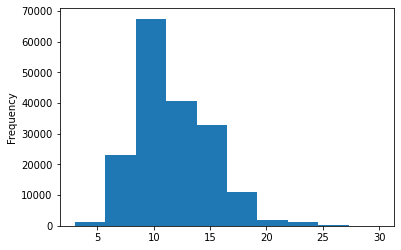

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist()

### Get list of sentences

In [ ]:
# Convert abstract text lines into lists
train_sentences =train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

len(train_sentences), len(test_sentences), len(val_sentences)

(180040, 30135, 30212)

In [ ]:
# View the first 10 lines of trian sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (Ml models require numeric labels)

In [ ]:
# One hot enode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

# Check how the labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label Encoded labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())

# Check how the label encoded traning labels looks like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from label encoder instances
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Experiments:

0. Naive Bayes with TF-IDF encoder(baseline).
1. Conv1D with token embeddings.
2. TensorFlow Hub Pretrained Feature Extractor
3. Conv1D with character embedding
4. Pretrained token embeddings (same as 2) + Character embeddings (same as 3)
5. Pretrained token embeddings + character embeddings + Positional embeddings









## Model 0: Getting a baseline 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())                
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation datasets
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
#Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2022-03-04 11:38:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-04 11:38:17 (59.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Preparing our data(text) into a numerical mode for Deep Sequence models
Before we start building deeper models we need to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

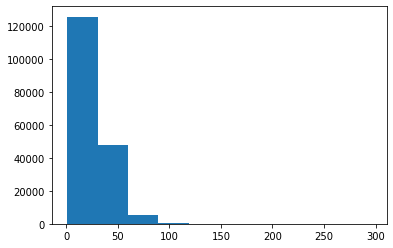

In [ ]:
# What the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens);

In [ ]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
# the maximum sequence length in the training set
max(sent_lens)

296

### create a TextVectorizer

In [ ]:
# How many words are in our vocabulary?
max_tokens = 68000

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                               output_sequence_length=55)

In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test our text vectorizer on ransom sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of the text: {len(target_sentence.split())}")
print(f"\nVectorized text\n: {text_vectorizer([target_sentence])}")

Text:
randomisation was stratified by centre , mediastinal bulk ( less than @ cm vs @ cm or more ) , and weight loss ( @ % or more vs less than @ % in the previous @ months ) .

Length of the text: 40

Vectorized text
: [[  934    10   810    22  1695  8662 12220   211    42   520    44   520
     16    69     3   174   264    16    69    44   211    42     5     2
    468    41     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# How many words in our training vocabulary?
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Create a custom Embbedding layer

In [ ]:
# Create token embbeding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                              output_dim=128,
                              mask_zero=True,
                              name="token_embedding")

In [ ]:
# Show example embedding
print(f"Sentence before vector:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n {vectorized_sentence}")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vector:
 randomisation was stratified by centre , mediastinal bulk ( less than @ cm vs @ cm or more ) , and weight loss ( @ % or more vs less than @ % in the previous @ months ) .

Sentence after vectorization:
 [[  934    10   810    22  1695  8662 12220   211    42   520    44   520
     16    69     3   174   264    16    69    44   211    42     5     2
    468    41     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Sentence after embedding:
 [[[-0.0303002   0.02181977  0.04495109 ... -0.02551403 -0.02135868
    0.03721416]
  [ 0.04188612 -0.01790298  0.00502335 ... -0.02405492  0.04926236
    0.02073256]
  [ 0.04165461 -0.02361506 -0.01368738 ... -0.0051076   0.02729679
   -0.03831338]
  ...
  [-0.04732071 -0.00498985 -0.03811711 ... -0.03775753 -0.0224171
    0.00090885]
  [-0.04732071 -0.00498985 -0.03811711 ... -0.03775753 -0.0224171


## Creating a DataSets (Making sure our data loads as fast as possible)

In [ ]:
# Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))

In [ ]:
# Take the TensorSliceDataset and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D

In [ ]:
# Model 1: Conv1D with token embedding
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputd
token_embeddings = token_embed(text_vectors) # creat embedding
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu")(token_embeddings) # Create embedding layer
x = layers.GlobalAveragePooling1D()(x) # Condense the output of our feature vector                
outputs = layers.Dense(num_classes, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy", # if our labels are integer form
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])                        

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 output_layer (Dense)        (None, 5)                 325   

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 77s 135ms/step - loss: 0.9248 - accuracy: 0.6358 - val_loss: 0.6871 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 78s 138ms/step - loss: 0.6609 - accuracy: 0.7554 - val_loss: 0.6377 - val_accuracy: 0.7686
Epoch 3/3
562/562 [==============================] - 76s 136ms/step - loss: 0.6188 - accuracy: 0.7756 - val_loss: 0.5984 - val_accuracy: 0.7842


In [ ]:
# Evaluate model
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5997 - accuracy: 0.7870


[0.5997450947761536, 0.7870051860809326]

In [ ]:
# Make predictions (our model predicts prediction probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.6084300e-01, 1.6434978e-01, 6.6228986e-02, 2.6805764e-01,
         4.0520586e-02],
        [3.9004117e-01, 3.3665970e-01, 1.2455983e-02, 2.5160265e-01,
         9.2404783e-03],
        [1.6896679e-01, 1.0904472e-02, 2.5572560e-03, 8.1752318e-01,
         4.8221584e-05],
        ...,
        [1.2872276e-05, 6.3867675e-04, 9.1317814e-04, 4.3698419e-06,
         9.9843091e-01],
        [5.8616787e-02, 4.9692824e-01, 7.1304008e-02, 5.9824772e-02,
         3.1332615e-01],
        [1.3639081e-01, 6.9219720e-01, 4.7435828e-02, 5.8621291e-02,
         6.5354884e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

### Model_1_results

In [ ]:
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.70051635111876,
 'f1': 0.7844799046599944,
 'precision': 0.7839574125291835,
 'recall': 0.7870051635111877}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Model 2: TensorFlow Hub Pretrained Feature Extractor

Universal Sentence Encoder (USE)

The paper used GloVe

In [ ]:
# Download pretrained tensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="Universal_sentence_encoder")

In [ ]:
# Test out embedding layer on random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"USE Embedded Sentence:\n {use_embedded_sentence[0][:30]}")
print(f"The shape of USE Embedded Sentence: {use_embedded_sentence.shape}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random Sentence:
 a retrospective cross-sectional study .
USE Embedded Sentence:
 [ 0.04287805  0.02592261  0.00215558 -0.0554698  -0.02985475 -0.02448132
  0.00955881  0.03988985  0.09813387  0.02506583 -0.03344597 -0.02276836
  0.07706374 -0.03788061 -0.05794436 -0.07553165 -0.01957065  0.0387824
  0.05425761 -0.10240889  0.01674834  0.05511303 -0.04123747 -0.0272507
 -0.02348427  0.01195921 -0.02586979 -0.03860223  0.00342397  0.04606115]
The shape of USE Embedded Sentence: (1, 512)
Length of sentence embedding: 512


In [ ]:
# Model 2: USE 
Inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(Inputs)
x= layers.Dense(128, activation="relu")(pretrained_embedding)
# Note: we can add more layers here if we want
Outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(Inputs,
                         Outputs, 
                         name="Model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])


In [ ]:
model_2.summary()

Model: "Model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 Universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model_2
history_model_2 = model_2.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 13s 18ms/step - loss: 0.9239 - accuracy: 0.6442 - val_loss: 0.7985 - val_accuracy: 0.6862
Epoch 2/3
562/562 [==============================] - 9s 17ms/step - loss: 0.7681 - accuracy: 0.7028 - val_loss: 0.7524 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7494 - accuracy: 0.7140 - val_loss: 0.7365 - val_accuracy: 0.7168


In [ ]:
# Evaluate model_2
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7384 - accuracy: 0.7160


[0.7384371161460876, 0.7160399556159973]

In [ ]:
# Make prediction with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.3416801e-01, 3.5908151e-01, 1.8204513e-03, 1.9742535e-01,
        7.5046588e-03],
       [3.2444394e-01, 5.0883746e-01, 3.1481511e-03, 1.6097443e-01,
        2.5960039e-03],
       [2.2155888e-01, 1.3758260e-01, 1.6422641e-02, 5.8397567e-01,
        4.0460236e-02],
       ...,
       [1.6128646e-03, 7.0149396e-03, 5.9485514e-02, 8.2517409e-04,
        9.3106151e-01],
       [3.7535732e-03, 5.5418413e-02, 1.8903868e-01, 1.5023050e-03,
        7.5028700e-01],
       [1.6087826e-01, 2.6976520e-01, 4.9497527e-01, 8.7814266e-03,
        6.5599918e-02]], dtype=float32)

In [ ]:
# Convert the prediction probabilities found with the feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate the results
model_2_results = calculate_results(y_true= val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.60399841122734,
 'f1': 0.7128235688502529,
 'precision': 0.7161533009002364,
 'recall': 0.7160399841122733}

# Model 3: Conv1D with Character Embedding

Paper which we are replicating stated that they have used a combination of token and character level embeddings.

previously we'have token-level embedding but we'll need to do similar steps for character level embedding

## Creating a character- level tokenizer

In [ ]:
# Making function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Test spliting non-character level sequence to characters
split_chars(random_train_sentence)

'a   r e t r o s p e c t i v e   c r o s s - s e c t i o n a l   s t u d y   .'

In [ ]:
# Convert data to character level splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# Calculate the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

In [ ]:
char_lens[0]

281

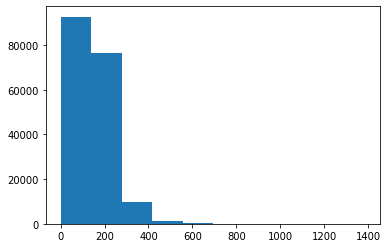

In [ ]:
# Check the distribution of sequence at character level
import matplotlib.pyplot as plt
plt.hist(char_lens);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# get all the keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV- out of vocabulary, '[UKN]')
char_vectorizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                                    output_sequence_length=output_seq_char_len,
                                                    
                                                     name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
# Test our character level vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of charified text: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"Length of vectorized char: {len(vectorized_chars[0])}")

Charified text:
 t h e   u s e   o f   a   p r e s s u r e   d o l o r i m e t e r   m a y   h a v e   s e r v e d   a s   a   f o r m   o f   i s c h e m i c   c o m p r e s s i o n   t r e a t m e n t   .
Length of charified text: 79

Vectorized chars:
 [[ 3 13  2 16  9  2  7 17  5 14  8  2  9  9 16  8  2 10  7 12  7  8  4 15
   2  3  2  8 15  5 19 13  5 21  2  9  2  8 21  2 10  5  9  5 17  7  8 15
   7 17  4  9 11 13  2 15  4 11 11  7 15 14  8  2  9  9  4  7  6  3  8  2
   5  3 15  2  6  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0

In [ ]:
# Making a character level embedding layer
char_embed = layers.Embedding(input_dim= len(char_vocab), # Number of different characters
                                  output_dim= 25, # this is set according to the paper :https://arxiv.org/pdf/1612.05251.pdf
                                  mask_zero=True,
                                  name="char_embed")

In [ ]:
# test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded char (after vectorization and embedding):\n {char_embed_example}")
print(f"Embedded char shape: {char_embed_example.shape}")

Charified text:
 t h e   u s e   o f   a   p r e s s u r e   d o l o r i m e t e r   m a y   h a v e   s e r v e d   a s   a   f o r m   o f   i s c h e m i c   c o m p r e s s i o n   t r e a t m e n t   .

Embedded char (after vectorization and embedding):
 [[[-0.01815842  0.03454927 -0.02881373 ...  0.0207551  -0.0093401
    0.04264995]
  [ 0.04566142  0.02616853 -0.00543796 ...  0.04099388 -0.03179581
   -0.03388854]
  [ 0.01639595  0.0492884  -0.006977   ... -0.02199781 -0.00887806
    0.04088029]
  ...
  [-0.01656203  0.00540211 -0.00923915 ...  0.0111872   0.04190249
    0.02327203]
  [-0.01656203  0.00540211 -0.00923915 ...  0.0111872   0.04190249
    0.02327203]
  [-0.01656203  0.00540211 -0.00923915 ...  0.0111872   0.04190249
    0.02327203]]]
Embedded char shape: (1, 290, 25)


In [ ]:
# Model 3: Conv1D with character Embedding
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  padding="same",
                  activation="relu",
                  )(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes,
                 activation="softmax",
                 name="Dense_layer")(x)
model_3 = tf.keras.Model(inputs,outputs,
                         name= "model_3_conv1d-char_embedding")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_conv1d-char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 Dense_layer (Dense)         (None, 5

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_char_dataset,                              
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data= val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))
                              

Epoch 1/3
562/562 [==============================] - 15s 25ms/step - loss: 1.2659 - accuracy: 0.4873 - val_loss: 1.0572 - val_accuracy: 0.5834
Epoch 2/3
562/562 [==============================] - 14s 24ms/step - loss: 1.0212 - accuracy: 0.5932 - val_loss: 0.9579 - val_accuracy: 0.6144
Epoch 3/3
562/562 [==============================] - 14s 24ms/step - loss: 0.9495 - accuracy: 0.6256 - val_loss: 0.8800 - val_accuracy: 0.6639


In [ ]:
# Evaluate model_3
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.9058 - accuracy: 0.6506


[0.9057714939117432, 0.6506354808807373]

In [ ]:
# Make predictions 
model_3_pred_probs = model_3.predict(val_char_dataset)

# Convert predictions to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds 

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 4, 1])>

In [ ]:
# Calculate results 
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.0635509069244,
 'f1': 0.6385928167514029,
 'precision': 0.6422367009557806,
 'recall': 0.6506355090692441}

# Model 4: Pretrained + character Embeddings
Steps:
1. Create a token-level embedding model (similar model_)
2. Create a character-level model (similar to `model_3` with a slight modification.
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to figure 1 and section 4.2 of the paper
5. Construct a model which takes token and character-level sequences as inputs and produces sequence label probabilities as output.

In [ ]:
#1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype= tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs= token_inputs,
                             outputs = token_output)
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs= char_bi_lstm)
# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                 char_model.output])
# 4. Create output layers - adding in Dropout, discussed in section-4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation= "relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs= output_layer,
                         name="model_4_toke_and_char_embeddings")

In [ ]:
model_4.summary()

Model: "model_4_toke_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 Universal_sentence_encoder (Ke  (None, 512)         256797824   ['

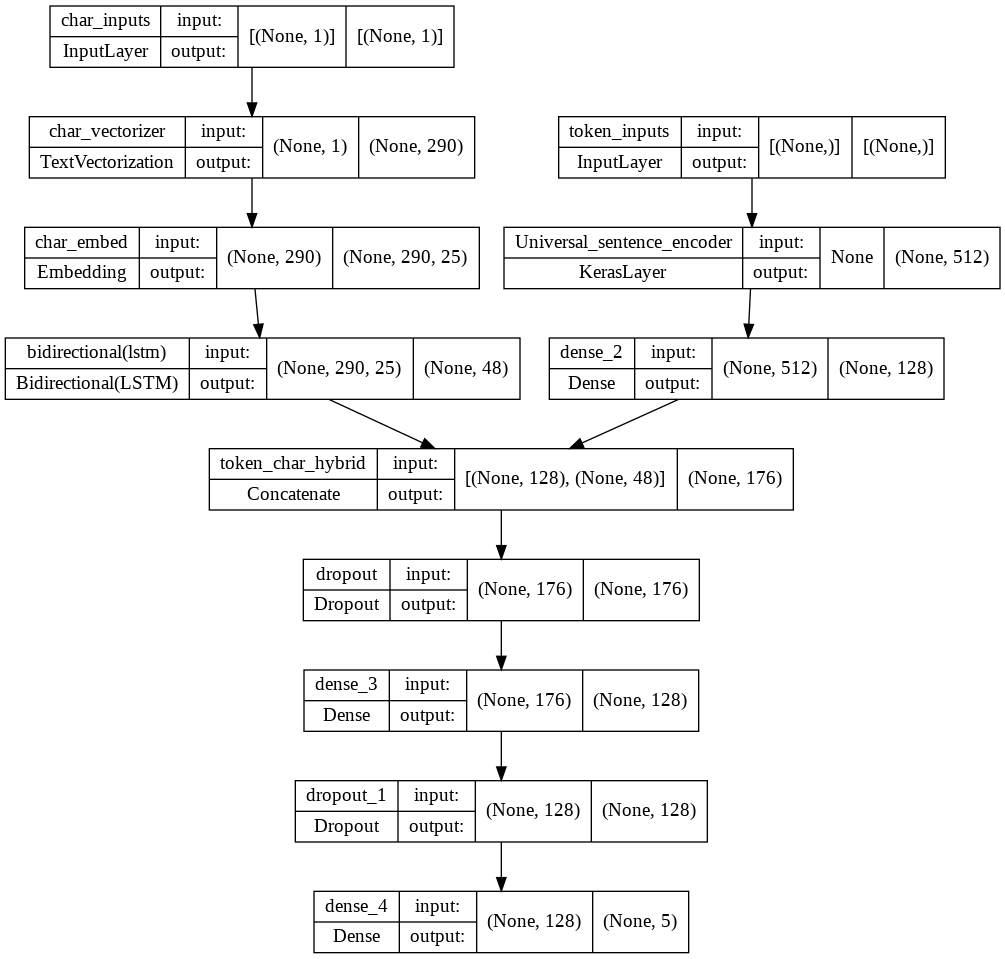

In [ ]:
# Plot hybrid token model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
# Combine chars and token into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # Combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above set for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # Combine data and labels

# prefetch and bacth val data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# check our trainin and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fitting the model_4
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 210s 355ms/step - loss: 0.9896 - accuracy: 0.6072 - val_loss: 0.7776 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 180s 321ms/step - loss: 0.8075 - accuracy: 0.6872 - val_loss: 0.7208 - val_accuracy: 0.7334
Epoch 3/3
562/562 [==============================] - 183s 326ms/step - loss: 0.7719 - accuracy: 0.7032 - val_loss: 0.6949 - val_accuracy: 0.7384


In [ ]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 65s 68ms/step - loss: 0.6972 - accuracy: 0.7333


[0.6972254514694214, 0.733251690864563]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[4.0528941e-01, 3.7866521e-01, 6.4360718e-03, 1.9954184e-01,
        1.0067405e-02],
       [3.6799541e-01, 4.1424504e-01, 4.8983623e-03, 2.1043406e-01,
        2.4271291e-03],
       [2.5811899e-01, 1.1965551e-01, 4.8625458e-02, 5.4336071e-01,
        3.0239325e-02],
       ...,
       [5.6824199e-04, 6.0111373e-03, 7.8411415e-02, 1.7589782e-04,
        9.1483331e-01],
       [7.9413876e-03, 7.3396169e-02, 2.0990621e-01, 3.1563090e-03,
        7.0559990e-01],
       [2.5451568e-01, 2.5614780e-01, 4.1288844e-01, 2.1665467e-02,
        5.4782752e-02]], dtype=float32)

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)

In [ ]:
# Get results of token-char hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [ ]:
## Model_5 : Transfer Learning with pretrained token embedding  + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.loc[train_df["line_number"]==28]

,target,text,line_number,total_lines
10492,CONCLUSIONS,"the data in this study , particularly when see...",28,28
135318,CONCLUSIONS,the only significant difference was found in t...,28,30
178211,BACKGROUND,national health and medical research council o...,28,28


### Create Positional Embeddings

In [ ]:
# How many different line number are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

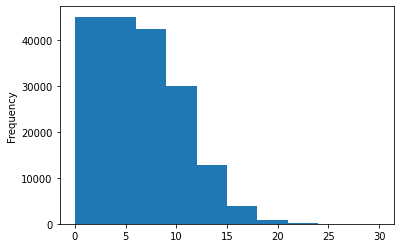

In [ ]:
# Check the distribution of lines
train_df["line_number"].plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

Now let one hot encode total line feature..

In [ ]:
# How many different number of line are there( lenght of the abstract)
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

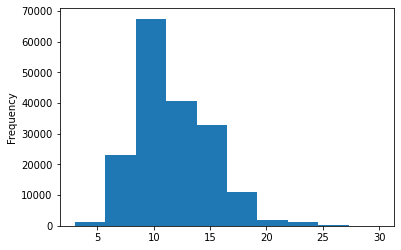

In [ ]:
# Plot the distribution of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the coverage of a "total_line" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# use Tensorflow to create one-hot-encoded tensor of "total_lines"
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities.
8. Combine the inputs of 1,2,3,4 and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs/model
token_inputs =layers.Input(shape=[],dtype="string", name = "token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128,activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Charcter-level Input/model
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. "line_number" input/model
line_number_inputs = layers.Input(shape=(15,),dtype=tf.float32, name="line_number_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined (token and char) embeddings into a tririd layer
tribrid_embdeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                  total_lines_model.output,
                                                                                  z])
# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embdeddings)

# Create model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs = output_layer,
                         name="model_5_tribrid_embedding_model")

In [ ]:
model_5.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 Universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

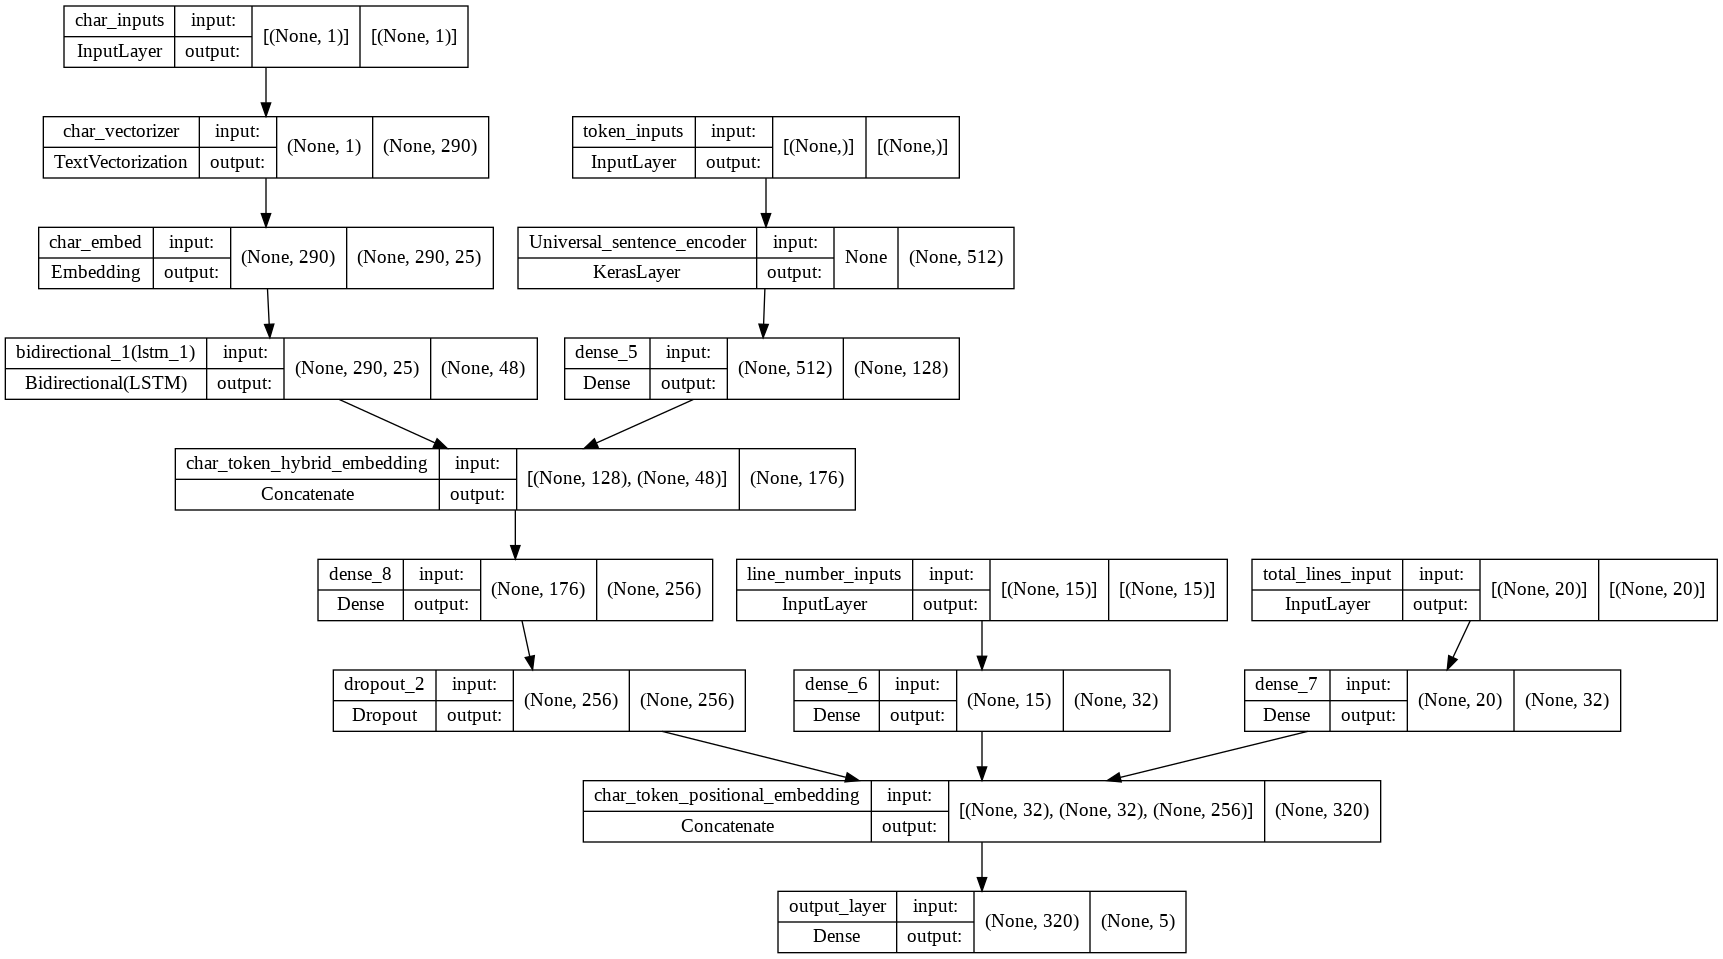

In [ ]:
# Plot model_5 
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

What is label smoothing?

For eg if our model gets too comfident on a single class ( e.g Its prediction probability is really high), it may get stuck on that class and not consider other classes....

Really confident: `[0.0, 0.0, 1.0, 0.0]`

what label smoothing does is it assigns some of the values from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

**Resource** for more on label smothing see the blog post from PyImageSearch

### Creating training and validation datasets (with all kinds of input data) using tf.data

In [ ]:
# Creating traing dataset
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_number_one_hot,
                                                               train_total_lines_one_hot,
                                                               train_sentences,
                                                               train_chars)) # should be in same order as created during model creation
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))
                                                  

# Conver it into batches and prefetch
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
 

In [ ]:
# Creattinf Validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_number_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars)) # should be in same order as created during model creation
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))
                                                  

# Conver it into batches and prefetch
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
 

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 194s 326ms/step - loss: 1.0982 - accuracy: 0.7268 - val_loss: 0.9844 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 179s 318ms/step - loss: 0.9685 - accuracy: 0.8129 - val_loss: 0.9506 - val_accuracy: 0.8281
Epoch 3/3
562/562 [==============================] - 179s 318ms/step - loss: 0.9502 - accuracy: 0.8224 - val_loss: 0.9404 - val_accuracy: 0.8341


In [ ]:
# make predictions 
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 68s 68ms/step


array([[0.4813621 , 0.10524078, 0.01268846, 0.38003653, 0.02067211],
       [0.52150834, 0.10711379, 0.05457548, 0.30430442, 0.01249803],
       [0.29082176, 0.129905  , 0.12767841, 0.38275078, 0.06884396],
       ...,
       [0.03175088, 0.10208741, 0.03867123, 0.0310217 , 0.79646873],
       [0.03015372, 0.2782123 , 0.07501163, 0.02708908, 0.58953327],
       [0.1929053 , 0.6523318 , 0.08347774, 0.03404215, 0.03724306]],
      dtype=float32)

In [ ]:
# Convert pred probs to labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate results 
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.39732556600026,
 'f1': 0.8331761619515851,
 'precision': 0.8330776497052446,
 'recall': 0.8339732556600027}

# Compare model Results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_1_results,
                                  "model_2_pretrained_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.700516,0.783957,0.787005,0.784480
model_2_pretrained_token_embedding,71.603998,0.716153,0.716040,0.712824
model_3_custom_char_embedding,65.063551,0.642237,0.650636,0.638593
model_4_hybrid_char_token_embedding,73.325169,0.735757,0.733252,0.730565
model_5_pos_char_token_embedding,83.397326,0.833078,0.833973,0.833176


In [ ]:
# making accuracy at same scale to others
all_model_results["accuracy"]= all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.721832,0.718647,0.721832,0.698925
model_1_custom_token_embedding,0.787005,0.783957,0.787005,0.784480
model_2_pretrained_token_embedding,0.716040,0.716153,0.716040,0.712824
model_3_custom_char_embedding,0.650636,0.642237,0.650636,0.638593
model_4_hybrid_char_token_embedding,0.733252,0.735757,0.733252,0.730565
model_5_pos_char_token_embedding,0.833973,0.833078,0.833973,0.833176


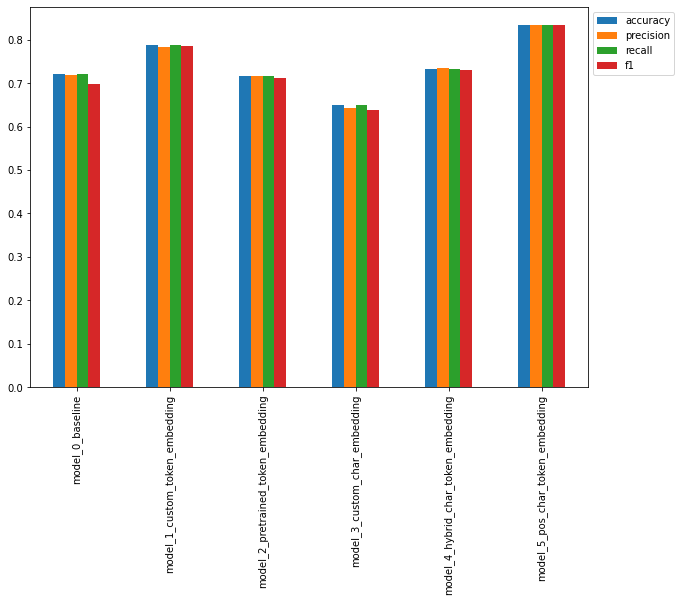

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));


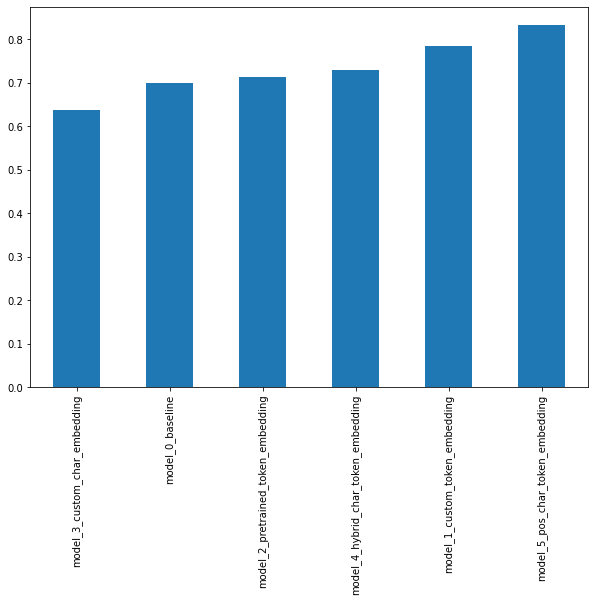

In [ ]:
# F1- scores for all the model sorted
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7));

In [ ]:
# Save the model
model_5.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# load saved model
model_5_loaded = tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
model_5_loaded.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 Universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     